# Initial Rocket 

Drafting simulation for EuRoC24. Using old artifacts atm.

In [66]:
import datetime
import matplotlib.pyplot as plt
from rocketpy import Environment, SolidMotor, Rocket, Flight

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Setup

### 1 - Environment


Gravity Details

Acceleration of gravity at surface level:    9.8007 m/s²
Acceleration of gravity at   1.000 km (ASL): 9.7981 m/s²


Launch Site Details

Launch Date: 2024-10-12 12:00:00 UTC
Launch Site Latitude: 39.41648°
Launch Site Longitude: -8.29087°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 44425.76 W    4376372.15 N
Launch Site UTM zone: 30S
Launch Site Surface Elevation: 140.0 m


Atmospheric Model Details

Atmospheric Model Type: custom_atmosphere
custom_atmosphere Maximum Height: 1.000 km


Surface Atmospheric Conditions

Surface Wind Speed: 5.72 m/s
Surface Wind Direction: 290.46°
Surface Wind Heading: 110.46°
Surface Pressure: 996.54 hPa
Surface Temperature: 287.24 K
Surface Air Density: 1.209 kg/m³
Surface Speed of Sound: 339.72 m/s


Earth Model Details

Earth Radius at Launch site: 6369.56 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034



Gravity Model Plots


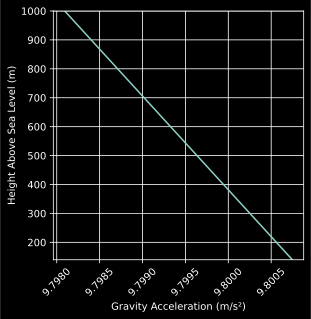



Atmospheric Model Plots


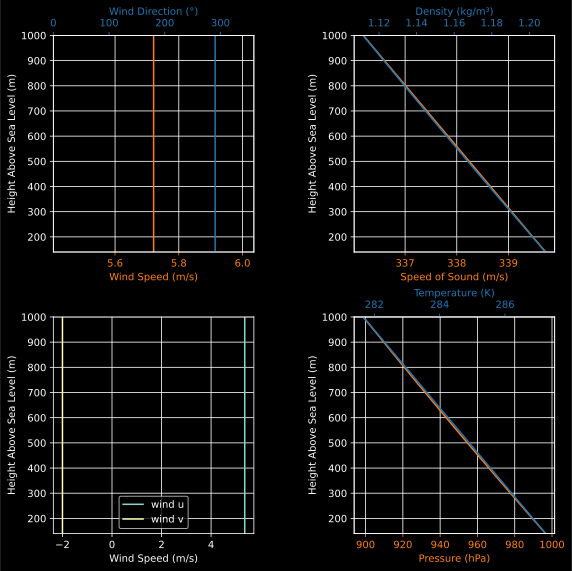

In [67]:
# Rough figures from google maps
env = Environment(
    latitude=39.416477289551466, 
    longitude=-8.290872787200357, 
    elevation=140, 
    date=(2024, 10, 12, 12)
)

env.set_atmospheric_model(
    type="custom_atmosphere", # use "Forecast" for GFS model
    pressure = None, # using ISA profile
    temperature = None, # using ISA profile
    wind_u = [(0, 5.36)], # Wind Speed East m/s: x, y -> altitude, windspeed (+/- for direction)
    wind_v = [(0, -2)], # Wind Speed North m/s: x, y -> altitude, windspeed (+/- for direction)
)

env.all_info()

### 2 - Motor

Nozzle Details
Nozzle Radius: 0.0375 m
Nozzle Throat Radius: 0.0125 m

Grain Details
Number of Grains: 3
Grain Spacing: 0.005 m
Grain Density: 1815 kg/m3
Grain Outer Radius: 0.0375 m
Grain Inner Radius: 0.029 m
Grain Height: 0.157 m
Grain Volume: 0.000 m3
Grain Mass: 0.506 kg

Motor Details
Total Burning Time: 5.3 s
Total Propellant Mass: 1.518 kg
Average Propellant Exhaust Velocity: 2260.216 m/s
Average Thrust: 647.384 N
Maximum Thrust: 764.97 N at 2.043 s after ignition.
Total Impulse: 3431.136 Ns



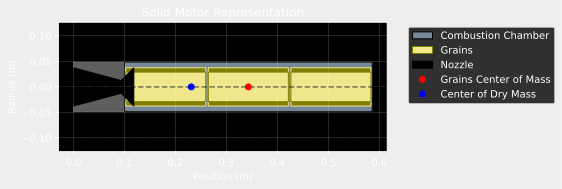

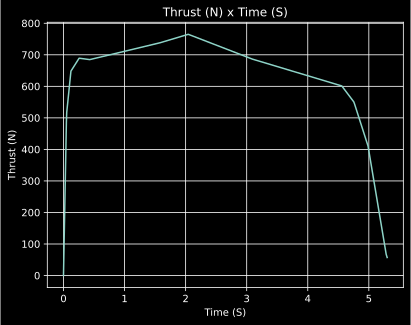

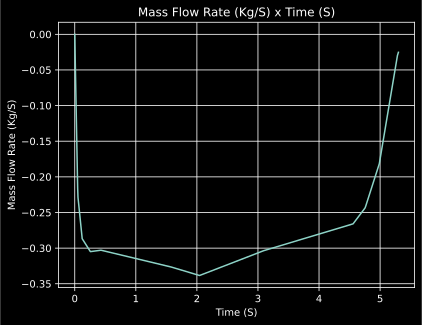

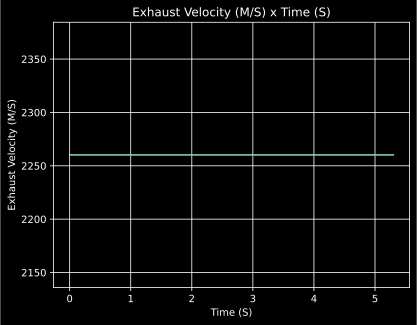

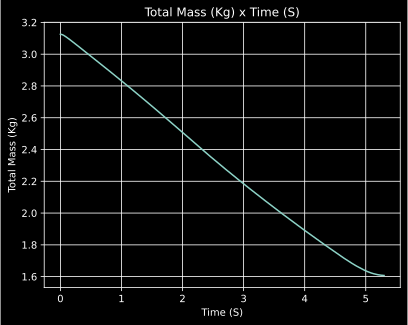

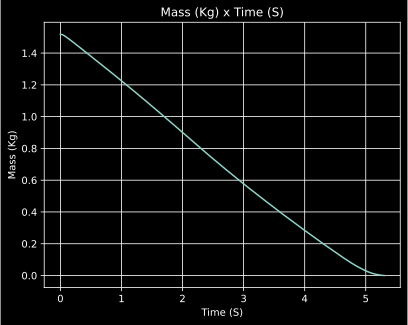

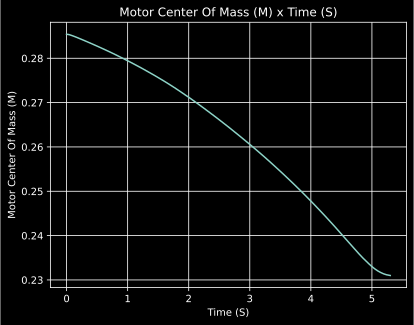

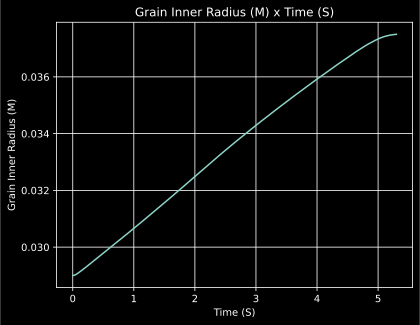

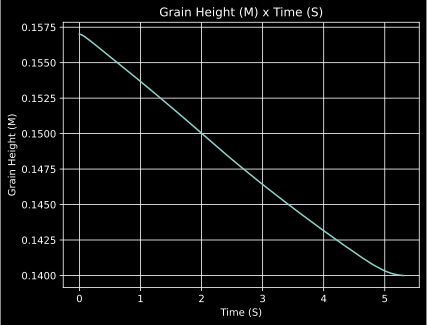

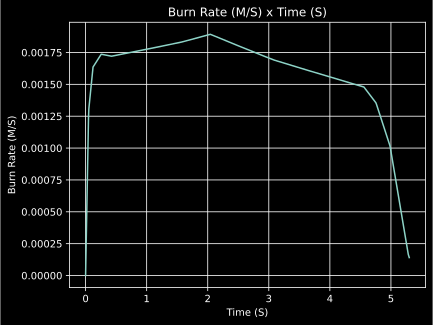

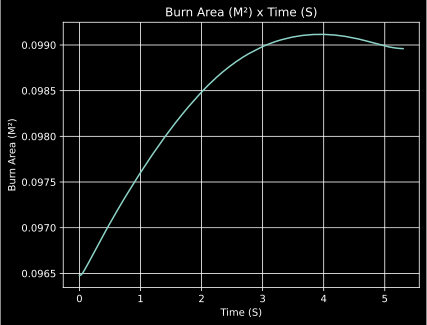

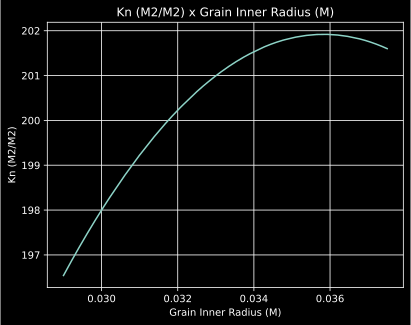

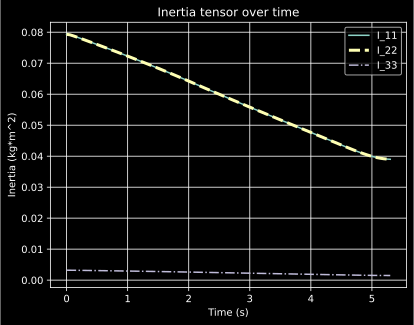

In [68]:
PRO75L645 = SolidMotor(
    thrust_source="../Mach24/Sim Files/Cesaroni_3419L645-P.eng", 
    dry_mass=1.607, # kilograms
    dry_inertia=(0.039, 0.039, 0.0015), # kg*m^2
    nozzle_radius = 37.5 / 1000, # of nozzle exit in meters
    grain_number=3, # Number of propellant grains
    grain_density=1815, # kg/m^3
    grain_outer_radius = 37.5 / 1000, # meters
    grain_initial_inner_radius=29 / 1000, # meters
    grain_initial_height=157 / 1000, # meters
    grain_separation=5 / 1000, # meters
    grains_center_of_mass_position=0.343, 
    center_of_dry_mass_position=0.231, 
    nozzle_position = 0.0, # relative to the combustion chamber
    burn_time=5.3, # seconds
    throat_radius=12.5 / 1000, # meters
    coordinate_system_orientation="nozzle_to_combustion_chamber" # Orientation of the coordinate system -> EXTREMLY IMPORTANT
)
PRO75L645.all_info()


### 3 - Rocket

In [70]:
rocket = Rocket(
    radius=106 / 2000, # (r) body in meters
    mass=5.544, # kg
    inertia=(3.8 , 3.8, 0.01), # Moments of inertia of the rocket in kg*m^2
    power_off_drag = "../Mach24/Sim Files/DragOffCSV.csv", # power-off drag curve csv
    power_on_drag = "../Mach24/Sim Files/DragOnCSV.csv", # power-on drag curve csv
    center_of_mass_without_motor=87.1 / 100, 
    coordinate_system_orientation="tail_to_nose" # MUST be relative to the coordinate system defined in the motor
)

rail_buttons = rocket.set_rail_buttons(
    upper_button_position=0.618, # relative to the rocket nose
    lower_button_position=0.230, # relative to the rocket nose
    angular_position=45, # degrees
)

rocket.add_motor(PRO75L645, position=0)

### 4 - Aero surfaces

In [71]:
nose_cone = rocket.add_nose(length=0.410, kind="vonKarman", position=1.815)

In [72]:
fin_set = rocket.add_trapezoidal_fins(
    n=3, 
    root_chord=0.25, # meters
    tip_chord=0.112, # meters
    span=0.152, # meters
    position=0.345, # relative to the rocket nose
    cant_angle=0, # radians
    # airfoil=("AirfoilDegreesCSV.csv", "degrees"), # Airfoil profile of the fins -> .csv file and declare your unit of measurment (radians OR degrees)
)


In [ ]:
tail = rocket.add_tail(
    top_radius = 106 / 2000, # meters
    bottom_radius=0.04, # meters
    length=0.08, # meters
    position=0.08 # relative to the rocket nose
)

### 5 - Recovery

In [74]:
main_para = rocket.add_parachute(
    "Main", # name
    cd_s = 1.0, # Drag coefficient of the parachute in m^2
    trigger = 200, # altitude in meters OR an event
    sampling_rate = 105, 
    lag = 1.5, # seconds
    noise = (0, 8.3, 0.5), 
)

drogue_para = rocket.add_parachute(
    "Drogue", # name
    cd_s = 0.313, # Drag coefficient of the parachute in m^2
    trigger = "apogee", # altitude in meters OR an event
    sampling_rate = 105,  
    lag = 1.5, # seconds
    noise = (0, 8.3, 0.5),
)


Inertia Details

Rocket Mass: 5.544 kg (without motor)
Rocket Dry Mass: 7.151 kg (with unloaded motor)
Rocket Loaded Mass: 8.669 kg (with loaded motor)
Rocket Inertia (with unloaded motor) 11: 4.349 kg*m2
Rocket Inertia (with unloaded motor) 22: 4.349 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.011 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.053 m
Rocket Frontal Area: 0.008825 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.144 m
Rocket Center of Dry Mass - Nozzle Exit: 0.727 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.384 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.067 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 13.157/rad

Center of Pressure

Nose Cone Center of Pr

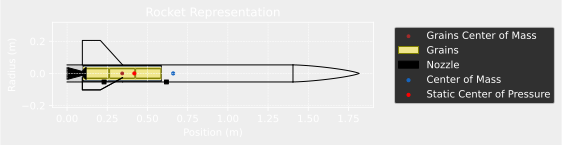


Mass Plots
----------------------------------------


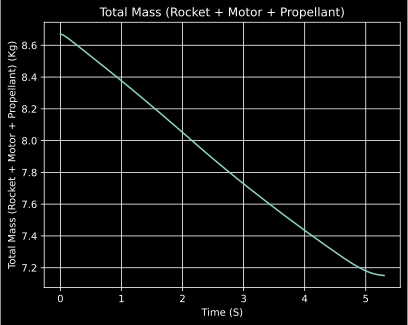

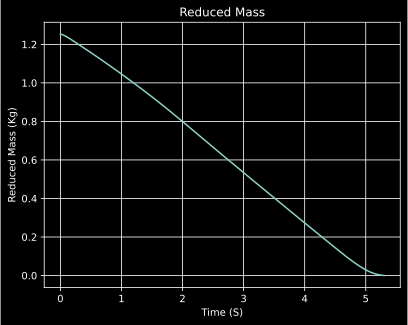


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


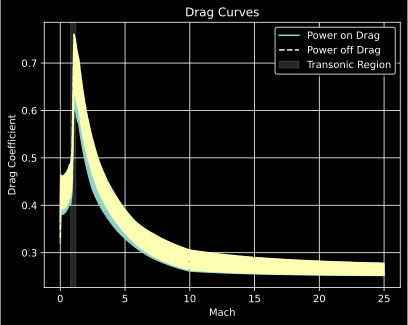


Stability Plots
--------------------


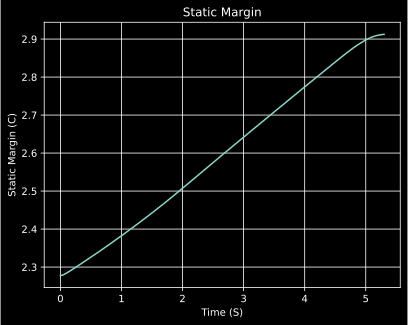

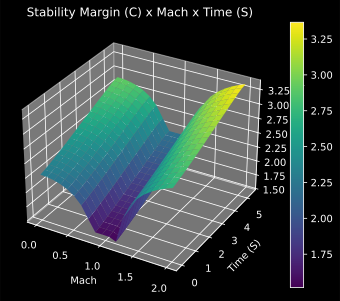


Thrust-to-Weight Plot
----------------------------------------


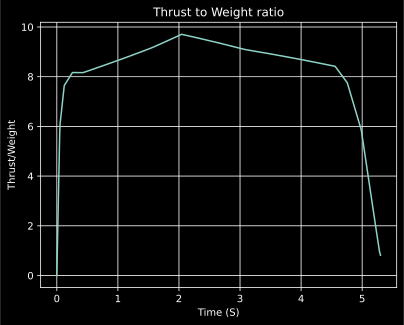

In [75]:
rocket.all_info()

## Flight


Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 140.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 0.601 | e1: -0.026 | e2: 0.035 | e3: -0.798
Euler Angles - Spin φ : 0.00° | Nutation θ: -5.00° | Precession ψ: -106.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: 2.278 c


Surface Wind Conditions

Frontal Surface Wind Speed: 5.70 m/s
Lateral Surface Wind Speed: -0.45 m/s


Launch Rail

Launch Rail Length: 4 m
Launch Rail Inclination: 85.00°
Launch Rail Heading: 106.00°


Rail Departure State

Rail Departure Time: 0.360 s
Rail Departure Velocity: 21.533 m/s
Rail Departure Stability Margin: 2.309 c
Rail Departure Angle of Attack: 15.159°
Rail Departure Thrust-Weight Ratio: 8.163
Rail Departure Reynolds Number: 1.564e+05


Burn out State

Burn out time: 5.300 s
Altitude at burn out: 1100.188 m (ASL) | 960.188 m (AGL)
Rocket speed at burn out: 312.715 m/s
Freestream ve

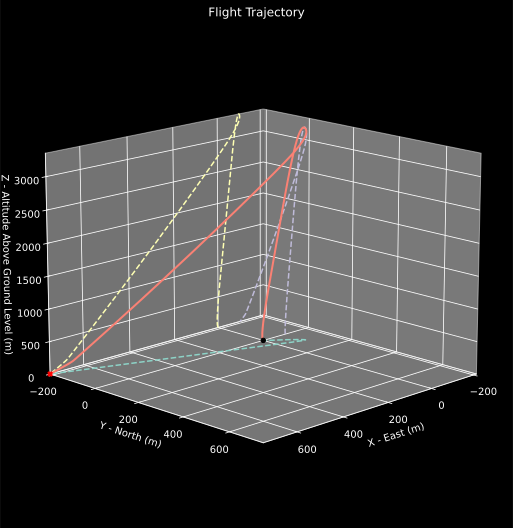



Trajectory Kinematic Plots



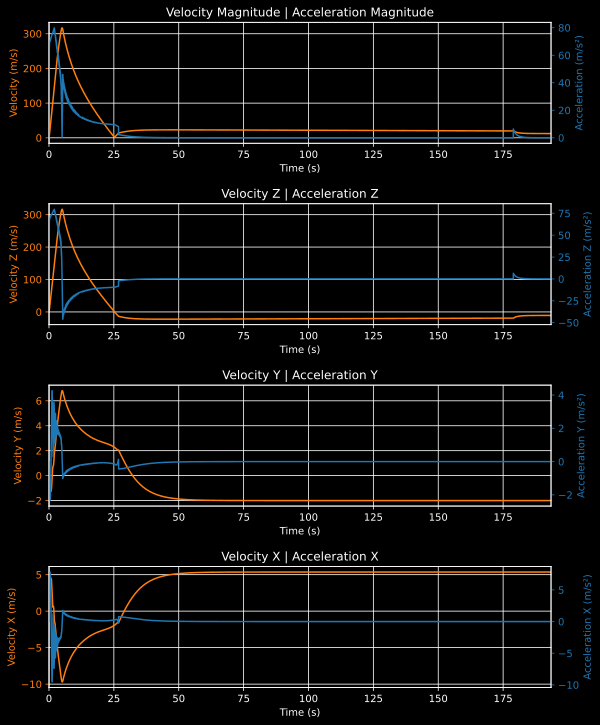



Angular Position Plots



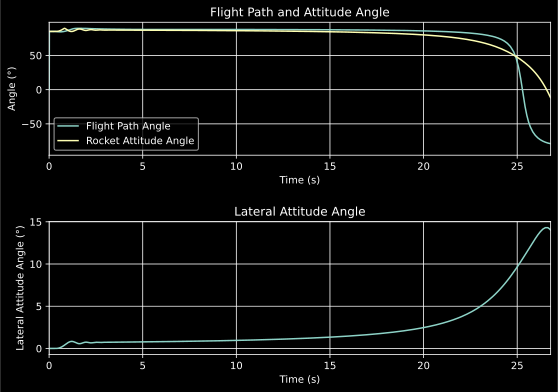



Path, Attitude and Lateral Attitude Angle plots



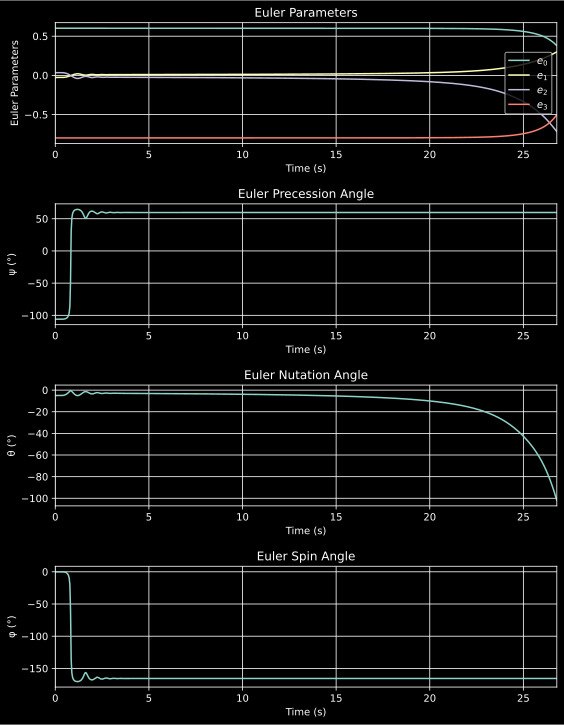



Trajectory Angular Velocity and Acceleration Plots



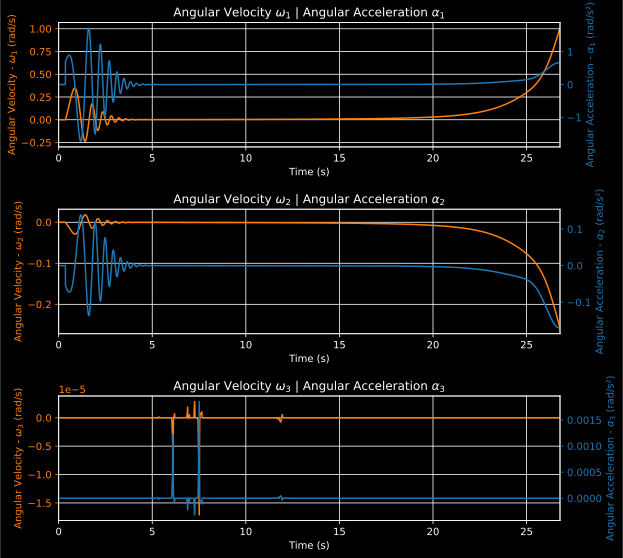



Aerodynamic Forces Plots



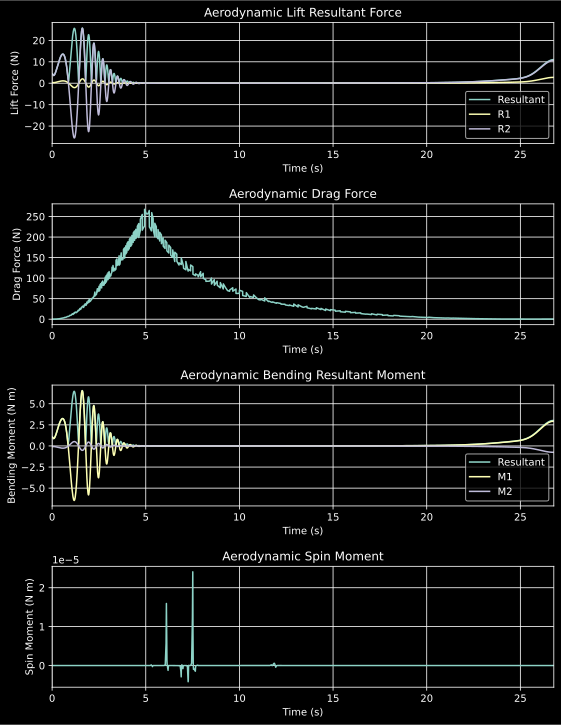



Rail Buttons Forces Plots



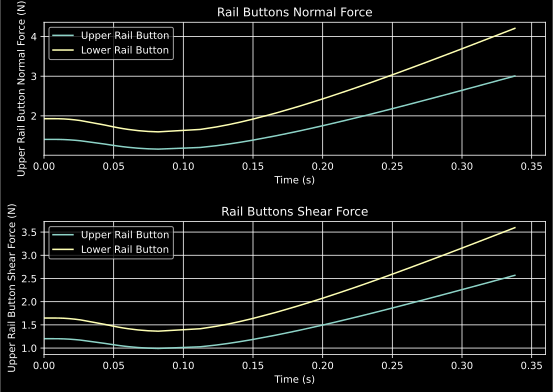



Trajectory Energy Plots



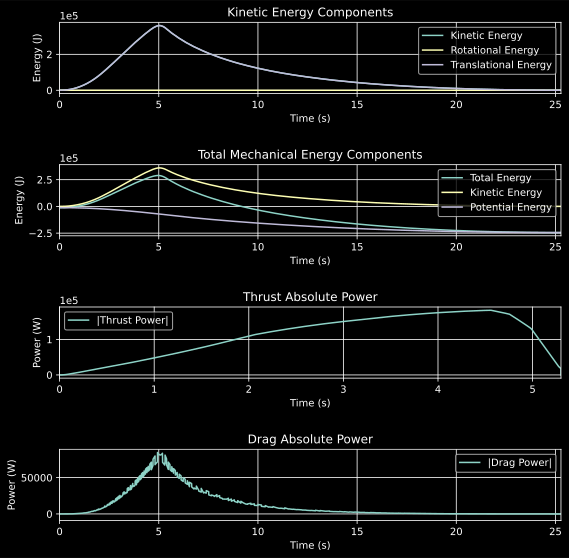



Trajectory Fluid Mechanics Plots



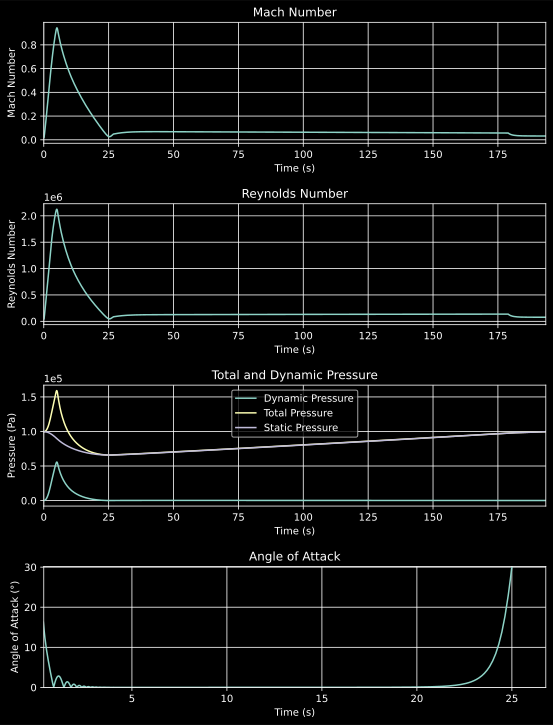



Trajectory Stability and Control Plots



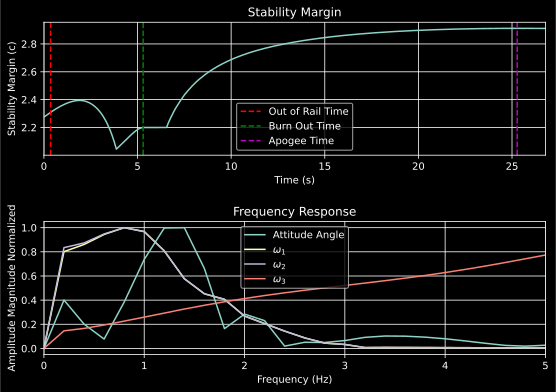



Rocket and Parachute Pressure Plots



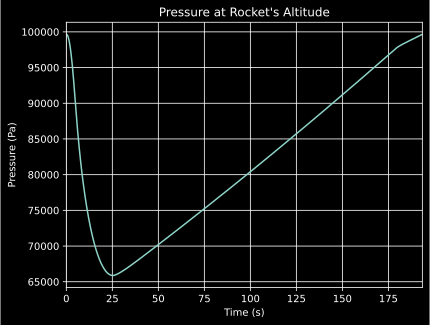


Parachute:  Main


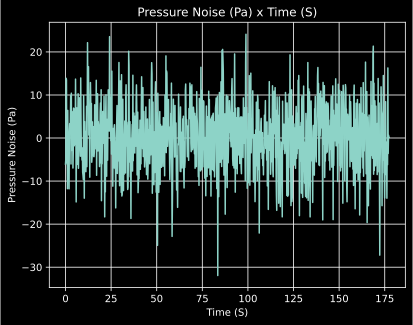

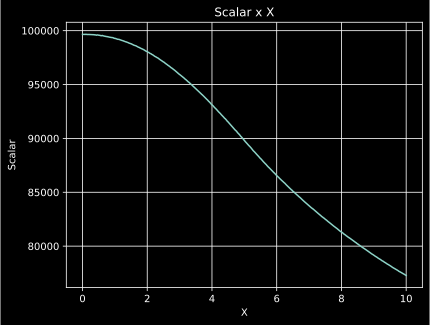

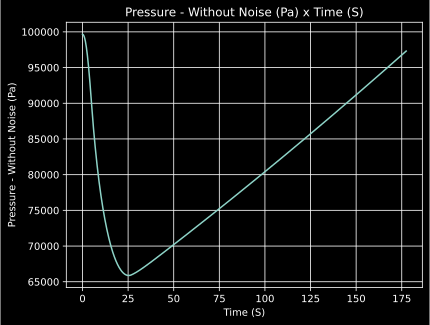


Parachute:  Drogue


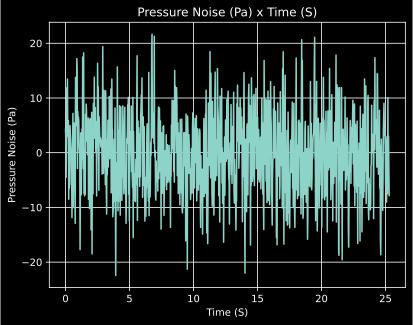

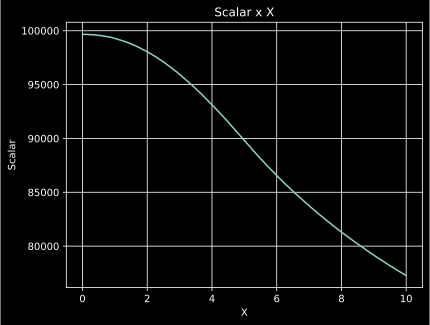

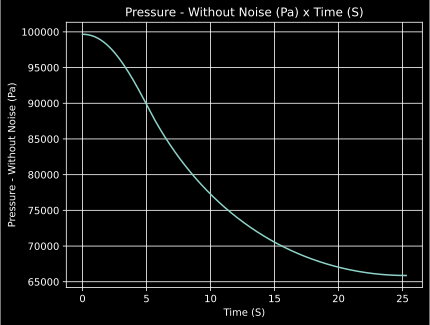

In [76]:
flight = Flight(
    rocket=rocket, 
    environment=env,  
    rail_length=4, # meters
    inclination=85, # launch rail (in degrees)
    heading = 106 # launch rail (in degrees)
)
flight.all_info()

## Export

In [77]:
flight.export_kml("InitialRocket.kml")

File  InitialRocket.kml  saved with success!
